# Analisis Runtun Waktu menggunakan Long Short Term Memory (LSTM)
LSTM adalah salah satu cabang ANN (Artificial Neural Network) yang dirancang khusus untuk menangani data sequensial (berurut). Maka dari itu LSTM sering digunakan untuk analisis runtun waktu, NLP (Natural Language Processing), Speech Recognition, dan lain-lain.

Untuk yang masih asing dengan LSTM, saya pikir <a href="https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21">link ini</a>  bisa menjelaskan dengan sangat baik.

Berikut ini merupakan penerapan LSTM dalam Analisis Runtun Waktu untuk memprediksi jumlah kasus COVID-19 di Indonesia.


In [1]:
# library

import numpy as np
import json
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
warnings.filterwarnings('ignore')

# Memanggil dan Mempersiapkan Data
#### Mengekstrak data COVID-19 melalui API 'mathdroid', selengkapnya bisa dilihat <a href="https://github.com/mathdroid/covid-19-api">disini</a> 


In [2]:
inacov_url = 'https://indonesia-covid-19.mathdro.id/api/harian' 
inacov = urllib.request.urlopen(inacov_url)
df = json.loads(inacov.read())
df = df['data']
df = pd.DataFrame(df)
df.head()

,harike,tanggal,jumlahKasusKumulatif,jumlahPasienSembuh,jumlahPasienMeninggal,jumlahPasienDalamPerawatan,jumlahKasusBaruperHari,jumlahKasusSembuhperHari,jumlahKasusMeninggalperHari,jumlahKasusDirawatperHari,persentasePasienSembuh,persentasePasienMeninggal,persentasePasiendalamPerawat,jumlahSpesimenDiperiksa,jumlahKasusDiperiksa,jumlahNegatif,spesimenDiperiksaBaruHarian,kasusDiperiksaBaruHarian,pdp,odp,penambahanKasusTerkonfirmasi,kasusSedangInvestigasiLapang,jumlahSpesimenDiperiksaTerki,jumlahKasusDiperiksaTerkini,hasilPositifTerkini,hasilNegatifTerkini,pdpTerkini,odpTerkini,suspekTerkini,jumlahProvinsiTerdampak,jumlahKabKotTerdampak,pembaruanTerakhir,fid
0,1,1583107200000,2.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,100.0,NaN,339.0,335.0,26873.0,NaN,NaN,NaN,5754.0,84481.0,6059415.0,4079605.0,549508.0,3498055.0,13439.0,33504.0,72986.0,34.0,508.0,1.607333e+12,1
1,2,1583193600000,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,341.0,337.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,3,1583280000000,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,372.0,356.0,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,4,1583366400000,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,388.0,371.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,5,1583452800000,4.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,0.0,100.0,NaN,450.0,422.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [3]:
# mengecek data yg hilang untuk setiap kolom

df.isnull().sum().sort_values(ascending=False)

spesimenDiperiksaBaruHarian     280
pembaruanTerakhir               280
jumlahKabKotTerdampak           280
jumlahProvinsiTerdampak         280
suspekTerkini                   280
odpTerkini                      280
pdpTerkini                      280
hasilNegatifTerkini             280
hasilPositifTerkini             280
jumlahKasusDiperiksaTerkini     280
jumlahSpesimenDiperiksaTerki    280
kasusSedangInvestigasiLapang    280
penambahanKasusTerkonfirmasi    280
odp                             190
pdp                             190
jumlahSpesimenDiperiksa          45
kasusDiperiksaBaruHarian          3
jumlahNegatif                     1
jumlahKasusDiperiksa              1
persentasePasiendalamPerawat      1
persentasePasienMeninggal         1
persentasePasienSembuh            1
jumlahKasusDirawatperHari         1
jumlahKasusMeninggalperHari       1
jumlahKasusSembuhperHari          1
jumlahKasusBaruperHari            1
jumlahPasienDalamPerawatan        1
jumlahPasienMeninggal       

#### Memilih kolom 'JumlahKasusBaruperHari' sebagai variabel yang akan dianalisis

In [4]:
confirmed = df[['jumlahKasusBaruperHari', 'harike']]
confirmed.dropna(axis=0, inplace=True)
confirmed = confirmed.rename(columns={'jumlahKasusBaruperHari' : 'Jumlah Kasus Baru', 'harike' : 'Hari'})

In [5]:
confirmed['Jumlah Kasus Baru'] = confirmed['Jumlah Kasus Baru'].astype('int64')
confirmed = confirmed.set_index('Hari')

#### Melihat stasioneritas data melalui visualisasi dan ADF-test

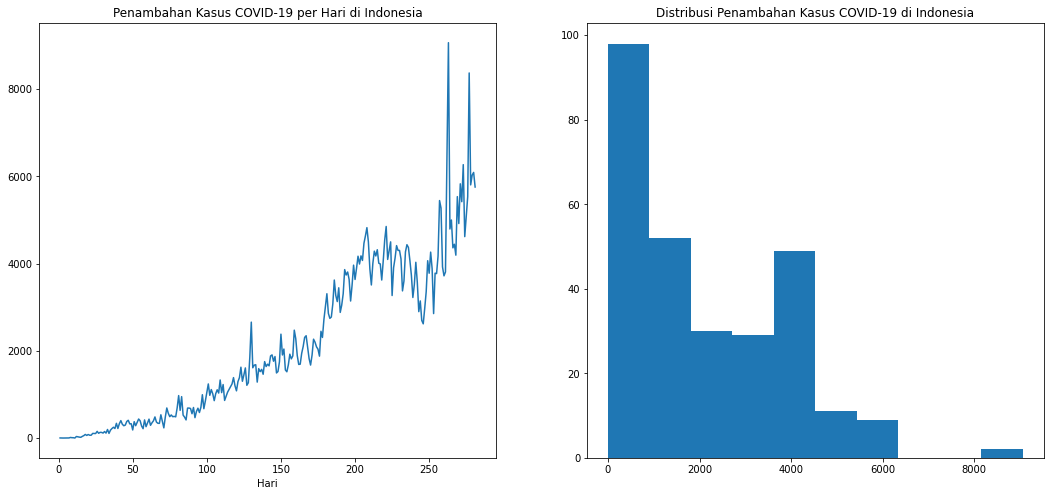

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(confirmed['Jumlah Kasus Baru'])
ax[0].set_xlabel('Hari')
ax[0].set_title('Penambahan Kasus COVID-19 per Hari di Indonesia')

ax[1].hist(confirmed['Jumlah Kasus Baru'])
ax[1].set_title('Distribusi Penambahan Kasus COVID-19 di Indonesia')

plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(confirmed['Jumlah Kasus Baru'].values)
print('ADF Statistics : ', adf_test[0])
print('p-value : ', adf_test[1])
if adf_test[1] < 0.05:
  print('Data Stasioner')
else:
  print('Data Tidak Stasioner')

ADF Statistics :  0.8929314904721164
p-value :  0.9929973835455745
Data Tidak Stasioner


Dari kedua tes diatas, dapat diketahui bahwa data tidak membentuk pola stasioner dan lebih condong membentuk pola trend naik.

#### Standarisasi dengan mengubah data menjadi dalam rentang (0, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(confirmed)

#### Membagi data train (untuk membuat model) dan test (membuat prediksi)

In [9]:
train_idx = int(len(data)*0.7)

train = data[:train_idx]
test = data[train_idx:]

#### Membuat fungsi untuk mengubah format data time series agar bisa dianalisis menggunakan LSTM.
Fungsi ini dibuat khusus untuk analisis time series univariat, agar bisa mengubah bentuk data yang 1 (variabel feature) variabel menjadi 2 variabel (variabel feature dan target).
Pada fungsi ini juga dibuat argumen 'step_size' untuk menentukan rentang dan shape dari variabel featurenya.

Note : jumlah 'step_size' bisa diubah sesuai kebutuhan.

Contoh:

| No | | feature |
|----| |---------|
| 1  | |   12    |
| 2  | |   15    |
| 3  | |   18    |
| 4  | |   11    |

dengan menggunakan step_size=2, data akan berubah menjadi:

| No | |  feature  | | target |
|----| |-----------| |--------|
| 1  | |  [12, 15] | |   18   |
| 2  | |  [15, 18] | |   11   |

In [10]:
def buat_data(data, step_size=1):
    X, y = [], []
    for i in range(len(data)):
      akhir = i + step_size
      if akhir >= len(data):
        break
      Xa = data[i:akhir]
      ya = data[akhir]
      X.append(Xa)
      y.append(ya)
    return np.array(X), np.array(y)

In [11]:
step_size = 2
X_train, y_train = buat_data(train, step_size=step_size)
X_test, y_test = buat_data(test, step_size=step_size)

In [12]:
X_train.shape

(194, 2, 1)

# Membuat model
Model dibuat dengan menggunakan Vanilla LSTM, yaitu LSTM dengan jumlah 1 hidden layer. Model terdiri atas:
- model Sequential() berarti kita telah membuat _fully connected layers_
- 50 buah LSTM layers pada input sekaligus hidden layer
- 1 buah output layer, dimana 1 layer digunakan karena kasus kali ini merupakan contoh kasus prediksi.
- _adam_ optimizer, pembaruan dari _stochastic gradient descent_ dalam mengupdate bobotnya.
- mse sebagai _loss function_

In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

Nilai MSE pada epoch ke-100 adalah 0.0006545113283209503


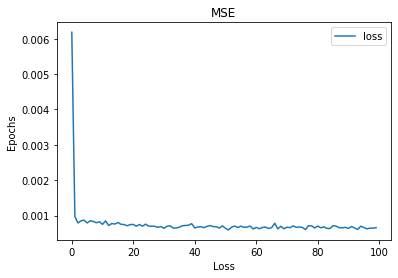

In [26]:
loss_df = pd.DataFrame(history.history)
loss_df['loss'].plot()
print('Nilai MSE pada epoch ke-100 adalah {}'.format(loss_df['loss'][99]))
plt.title('MSE')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

Nilai MSE yang didapatkan setelah 100 _epochs_ bisa dikatakan cukup kecil, dimana ini menandakan bahwa model yang dibangun cukup baik untuk melakukan prediksi

# Prediksi

In [ ]:
predict = model.predict(X_test)

In [ ]:
test = test[:-2]
test = np.reshape(test, test.shape[0])

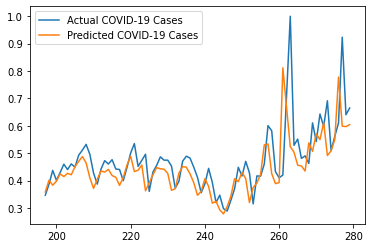

In [ ]:
plt.plot(confirmed.index[196:278], test, label='Actual COVID-19 Cases')
plt.plot(confirmed.index[196:278], forecasting, label='Predicted COVID-19 Cases')
plt.legend()